# MPMS rock magnetic experiments data analysis

This notebook visualizes and analyzes data from low-temperature experiments conducted on an MPMS instrument and exported to MagIC format.

In the following example, specimens from samples of diabase dikes from the East Central Minnesota batholith have undergone the following experiments:
- **RTSIRM**: in this experiment, a pulsed field was applied at room temperature (300 K) with the specimen then being cycled down to 10 K (-263.15ºC) and back to room temperature.
- **FC LTSIRM**: in this experiment, the specimens were cooled down to 10 K in the presence of a strong field and then warmed back up to room temperature.
- **ZFC LTSIRM**: in this experiment, the specimens were cooled down in a zero-field environment, pulsed with a strong field at 10 K and then warmed back up to room temperature.

## Import scientific python libraries

In [1]:
import rockmag as rmag
import pmagpy.ipmag as ipmag
import pmagpy.pmag as pmag
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500)

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Download and unpack data from MagIC

*At the moment, the ipmag.download_magic/ipmag.unpack_magic code is having a hard time with the IRM export file (see error below). This issue needs to be worked out. For the moment, we will manually unpack and work with the measurements file.*

In [2]:
ipmag.download_magic('ECMB 2018.TXT', 
                     dir_path = 'MPMS_data',
                     input_dir_path = 'MPMS_data')

working on:  'specimens\r'


IndexError: string index out of range

After unpacking the MagIC data, there is now a measurements table that we can import for analysis. 

In [2]:
file = './MPMS_data/measurements.txt'
measurements = pd.read_csv(file, sep='\t', skiprows=1)
measurements.head(1)

,Unnamed: 0,contribution_id,row_id,measurement,experiment,specimen,sequence,standard,quality,method_codes,instrument_codes,display_order,result_type,citations,treat_temp,treat_temp_decay_rate,treat_temp_dc_on,treat_temp_dc_off,treat_ac_field,treat_ac_field_decay_rate,treat_ac_field_dc_on,treat_ac_field_dc_off,treat_dc_field,treat_dc_field_decay_rate,treat_dc_field_ac_on,treat_dc_field_ac_off,treat_dc_field_theta,treat_dc_field_phi,treat_mw_power,treat_mw_time,treat_mw_integral,treat_mw_step,treat_step_num,meas_pos_x,meas_pos_y,meas_pos_z,meas_orient_theta,meas_orient_phi,meas_n_orient,meas_temp,meas_temp_change,meas_freq,meas_duration,meas_field_ac,meas_field_ac_theta,meas_field_ac_phi,meas_field_dc,meas_field_dc_theta,meas_field_dc_phi,inversion_height,inversion_residuals,magn_moment,magn_x,magn_x_sigma,magn_y,magn_y_sigma,magn_z,magn_z_sigma,magn_xyz_sigma,magn_induction,magn_b_x,magn_b_x_sigma,magn_b_y,magn_b_y_sigma,magn_b_z,magn_b_z_sigma,magn_b_111,magn_b_111_sigma,magn_b_xyz_sigma,magn_r2_det,dir_dec,dir_inc,dir_csd,magn_volume,magn_mass,magn_uncal,aniso_type,aniso_s,hyst_loop,hyst_sweep_rate,hyst_charging_mode,susc_chi_volume,susc_chi_mass,susc_chi_qdr_volume,susc_chi_qdr_mass,description,timestamp,software_packages,files,external_database_ids,derived_value,analysts
0,NaN,NaN,NaN,NED1-5c-IRM-VSM3-LP-HYS-218845-1,IRM-VSM3-LP-HYS-218845,NED1-5c,NaN,u,g,LP-HYS:LP-HYS-M,IRM-VSM3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,300.0,NaN,NaN,NaN,NaN,NaN,NaN,1.001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.1988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020:01:06:10:14:00.00,NaN,NaN,NaN,NaN,NaN


Now that we have imported the measurement pairs, we can look at the different experimental methods that have been applied to different specimens.

In [3]:
experiments = measurements.groupby(['specimen', 'method_codes']).size().reset_index().iloc[:, :2]
experiments

,specimen,method_codes
0,NED1-5c,LP-BCR-BF
1,NED1-5c,LP-HYS:LP-HYS-M
2,NED18-2c,LP-BCR-BF
3,NED18-2c,LP-CW-SIRM:LP-MC
4,NED18-2c,LP-CW-SIRM:LP-MW
5,NED18-2c,LP-FC
6,NED18-2c,LP-HYS:LP-HYS-M
7,NED18-2c,LP-ZFC
8,NED2-8c,LP-BCR-BF
9,NED2-8c,LP-CW-SIRM:LP-MC


## Extract data

We can now extract the MPMS data for a specific specimen using `rmag.extract_mpms_data` function

In [4]:
specimen_name = 'NED2-8c'
fc_data, zfc_data, rtsirm_cool_data, rtsirm_warm_data = rmag.extract_mpms_data(measurements, specimen_name)

## Plot data

 We can now plot these data using `plot_mpms_data`.

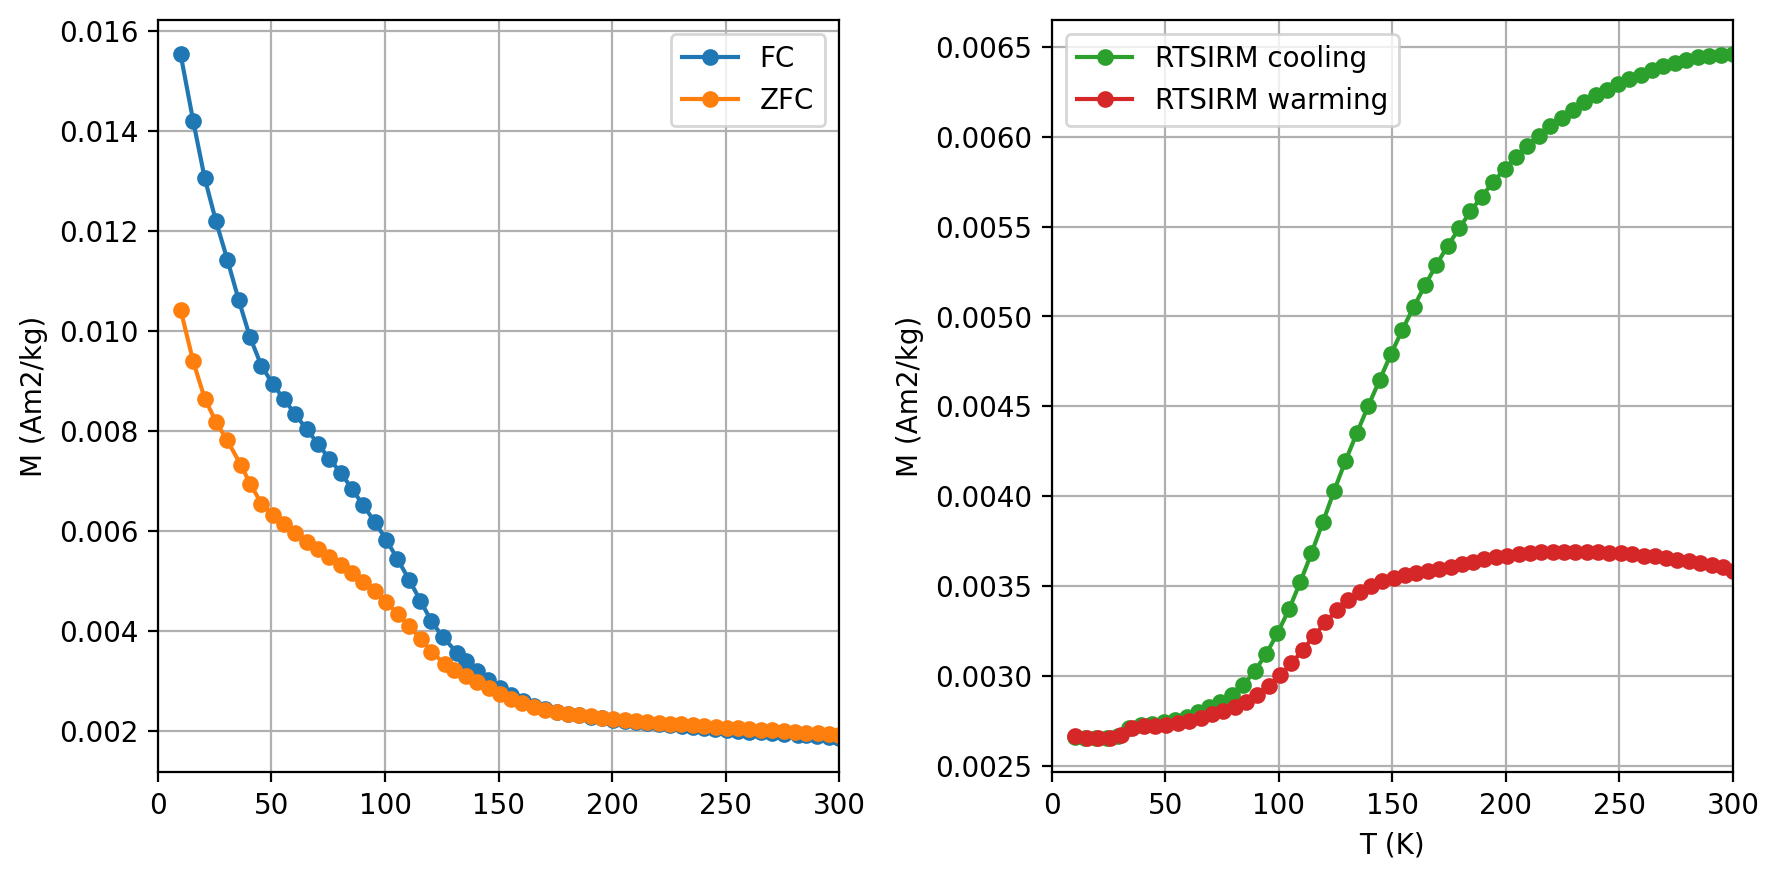

In [5]:
rmag.plot_mpms_data(fc_data, zfc_data, rtsirm_cool_data, rtsirm_warm_data)

### Plot the derivative

By setting `plot_derivative=True``, the derivative of the experimental data will be calculated and plotted. 

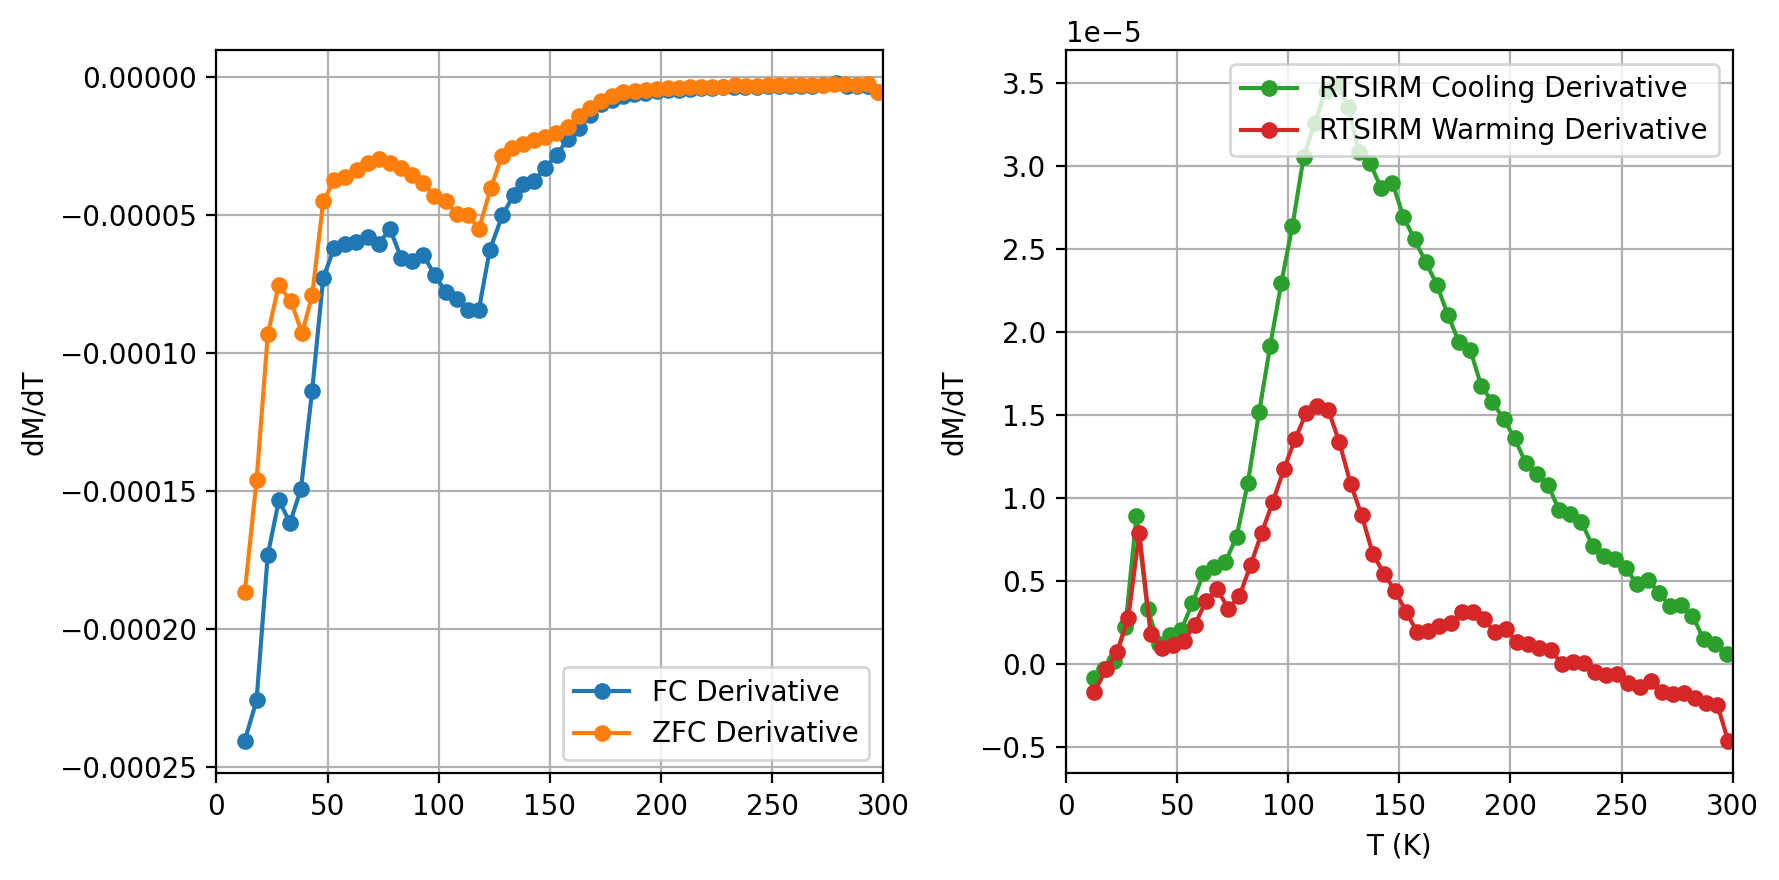

In [6]:
rmag.plot_mpms_data(fc_data, zfc_data, rtsirm_cool_data, rtsirm_warm_data, plot_derivative=True)

### Make interactive plots

Rather than the static plots made above, you may want to make interactive plots. This can be done by putting in the parameter `use_plotly=True`.

In [7]:
rmag.plot_mpms_data(fc_data, zfc_data, rtsirm_cool_data, rtsirm_warm_data, use_plotly=True)

In [8]:
rmag.plot_mpms_data(fc_data, zfc_data, rtsirm_cool_data, rtsirm_warm_data, use_plotly=True, plot_derivative=True)

The colors and symbols of the plots can be customized as in the example below:

In [8]:
rmag.plot_mpms_data(fc_data, zfc_data, rtsirm_cool_data, rtsirm_warm_data, 
                   fc_color='orange', zfc_color='purple', rtsirm_cool_color='blue', rtsirm_warm_color='darkred',
                   fc_marker='^', zfc_marker='o', rtsirm_cool_marker='*', rtsirm_warm_marker='s',
                   symbol_size=5, use_plotly=True)

## Fit the Verwey transition

To determine the Verwey transition, we can apply a method used within the IRM software where a function is fit to the derivative of the data outside of the Verwey transition and then subtracted off from the derivative. This process isolates the signal that can be interpreted to be associated with magnetite going through the Verwey transition. The peak of the derivative curve can then be determined.

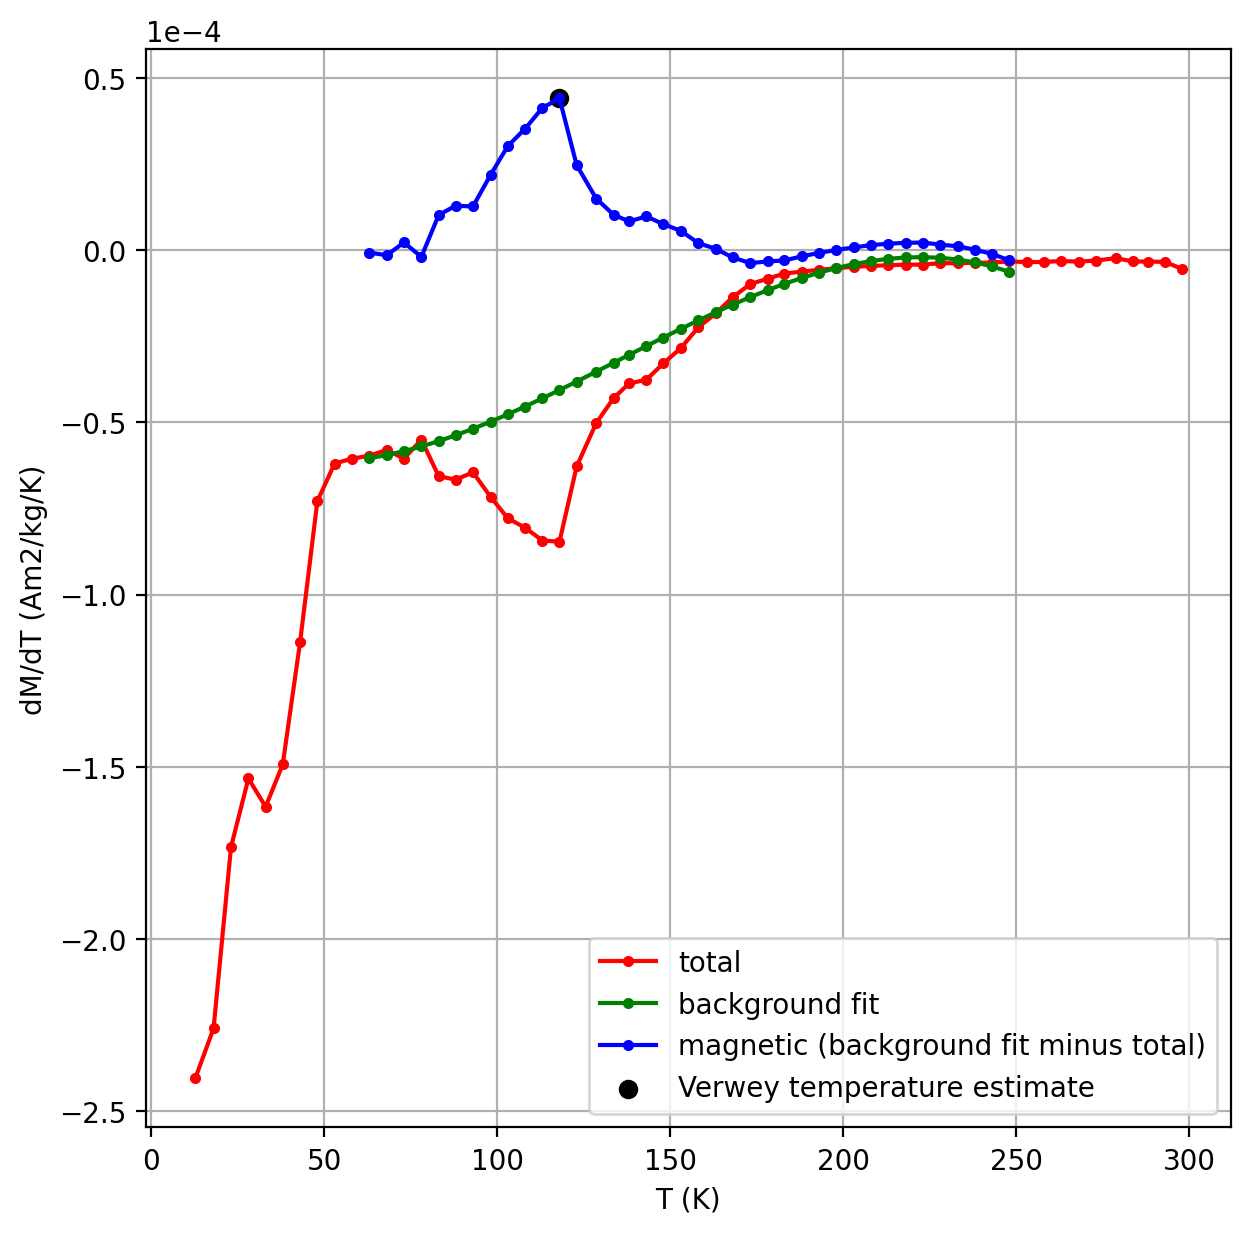

The T range for background fit is: 60 K to 250 K
The excluded T range is: 75 K to 150 K
The polynomial degree for background fit is: 3
The r-squared value for the background fit is: 0.985
The Verwey temperature estimate is: 118.0 K


(118.00710000000001, 0.9851609138395525)

In [9]:
temps = fc_data['meas_temp']
mags = fc_data['magn_mass']

rmag.verwey_estimate(temps, mags, t_range_background_min = 60,
           t_range_background_max = 250,
           excluded_t_min=75,
           excluded_t_max = 150,
           poly_deg = 3)

Just step before and after peak in order to calculate 2nd derivative zero crossing.

<img src="images/TVviewer_example.png" alt="NED2_8c_FC in TVviewed" style="width: 1000px;"/>

This peak fit is zero crossing of the second derivative.


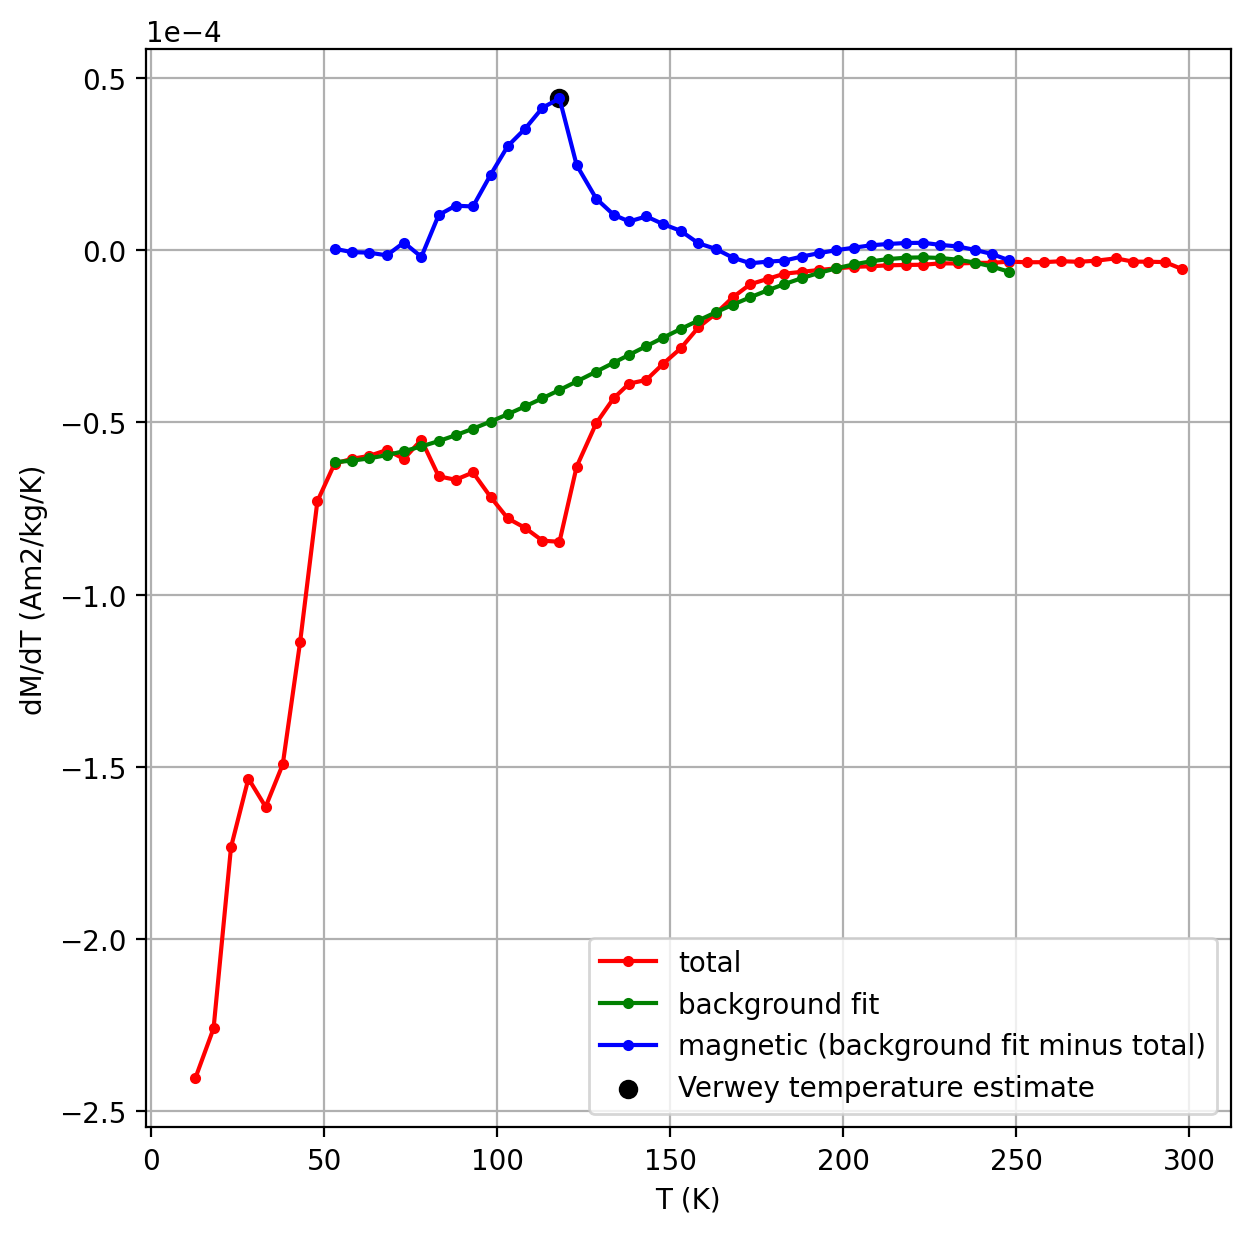

The T range for background fit is: 50 K to 250 K
The excluded T range is: 75 K to 150 K
The polynomial degree for background fit is: 3
The r-squared value for the background fit is: 0.99
The Verwey temperature estimate is: 118.0 K


(118.00710000000001, 0.9901165250383595)

In [39]:
file_path = './MPMS_data/NED2_8c_FC.txt'
NED2_8c_FC = read_and_process_file(file_path)

NED2_8c_FC.head()

temps = NED2_8c_FC['meas_temp']
mags = NED2_8c_FC['magn_mass']

Tv_fit(temps, mags, t_range_background_min = 50,
           t_range_background_max = 250,
           excluded_t_min=75,
           excluded_t_max = 150,
           poly_deg = 3)

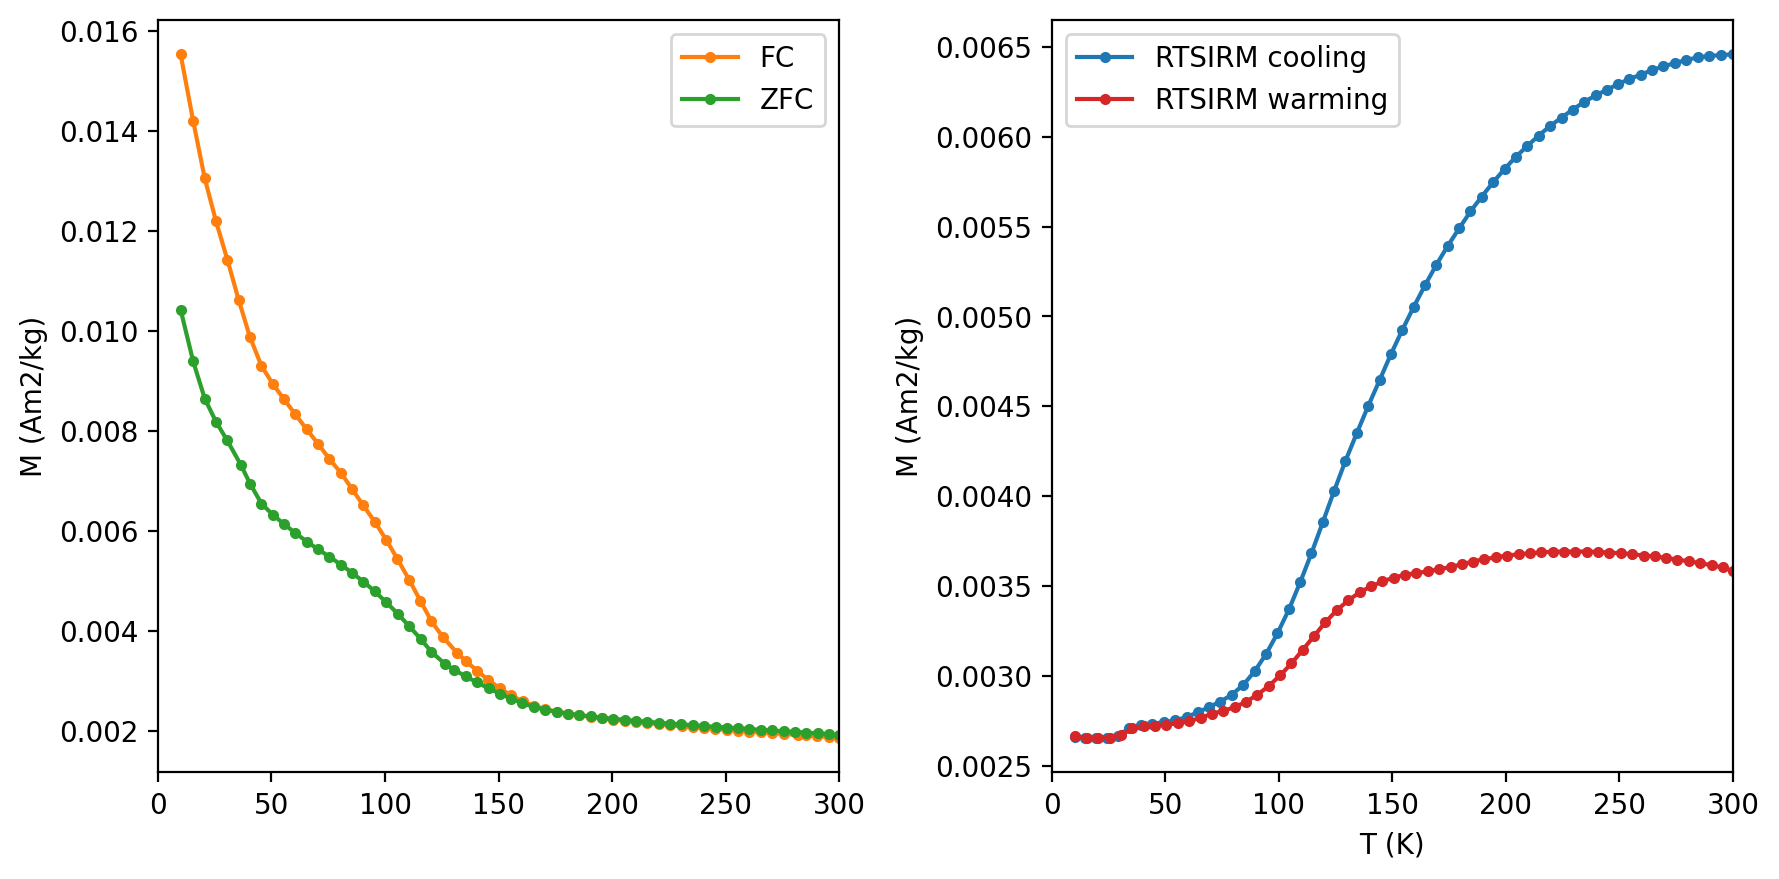

In [36]:
MPMS_file_path = './MPMS_data/NED2_8c_MPMS.csv'
MPMS_df = pd.read_csv(MPMS_file_path)
MPMS_FC, MPMS_ZFC, MPMS_RTSIRM_cool, MPMS_RTSIRM_warm = parse_MPMS_data(MPMS_df)

fig = plt.figure(figsize=(9,4.5))
ax0 = fig.add_subplot(1,2,1)
ax0.plot(MPMS_FC['T [K]'],MPMS_FC['M [Am2/kg]'],'.-',color='C1',label='FC')
ax0.plot(MPMS_ZFC['T [K]'],MPMS_ZFC['M [Am2/kg]'],'.-',color='C2',label='ZFC')
ax0.set_xlim(0,300)
ax0.set_ylabel('M (Am2/kg)')
ax0.legend()

ax1 = plt.subplot(1,2,2)
ax1.plot(MPMS_RTSIRM_cool['T [K]'],MPMS_RTSIRM_cool['M [Am2/kg]'],'.-',color='C0',label='RTSIRM cooling')
ax1.plot(MPMS_RTSIRM_warm['T [K]'],MPMS_RTSIRM_warm['M [Am2/kg]'],'.-',color='C3',label='RTSIRM warming')
ax1.set_xlim(0,300)
ax1.set_ylabel('M (Am2/kg)')
ax1.set_xlabel('T (K)')
ax1.legend()

fig.tight_layout()

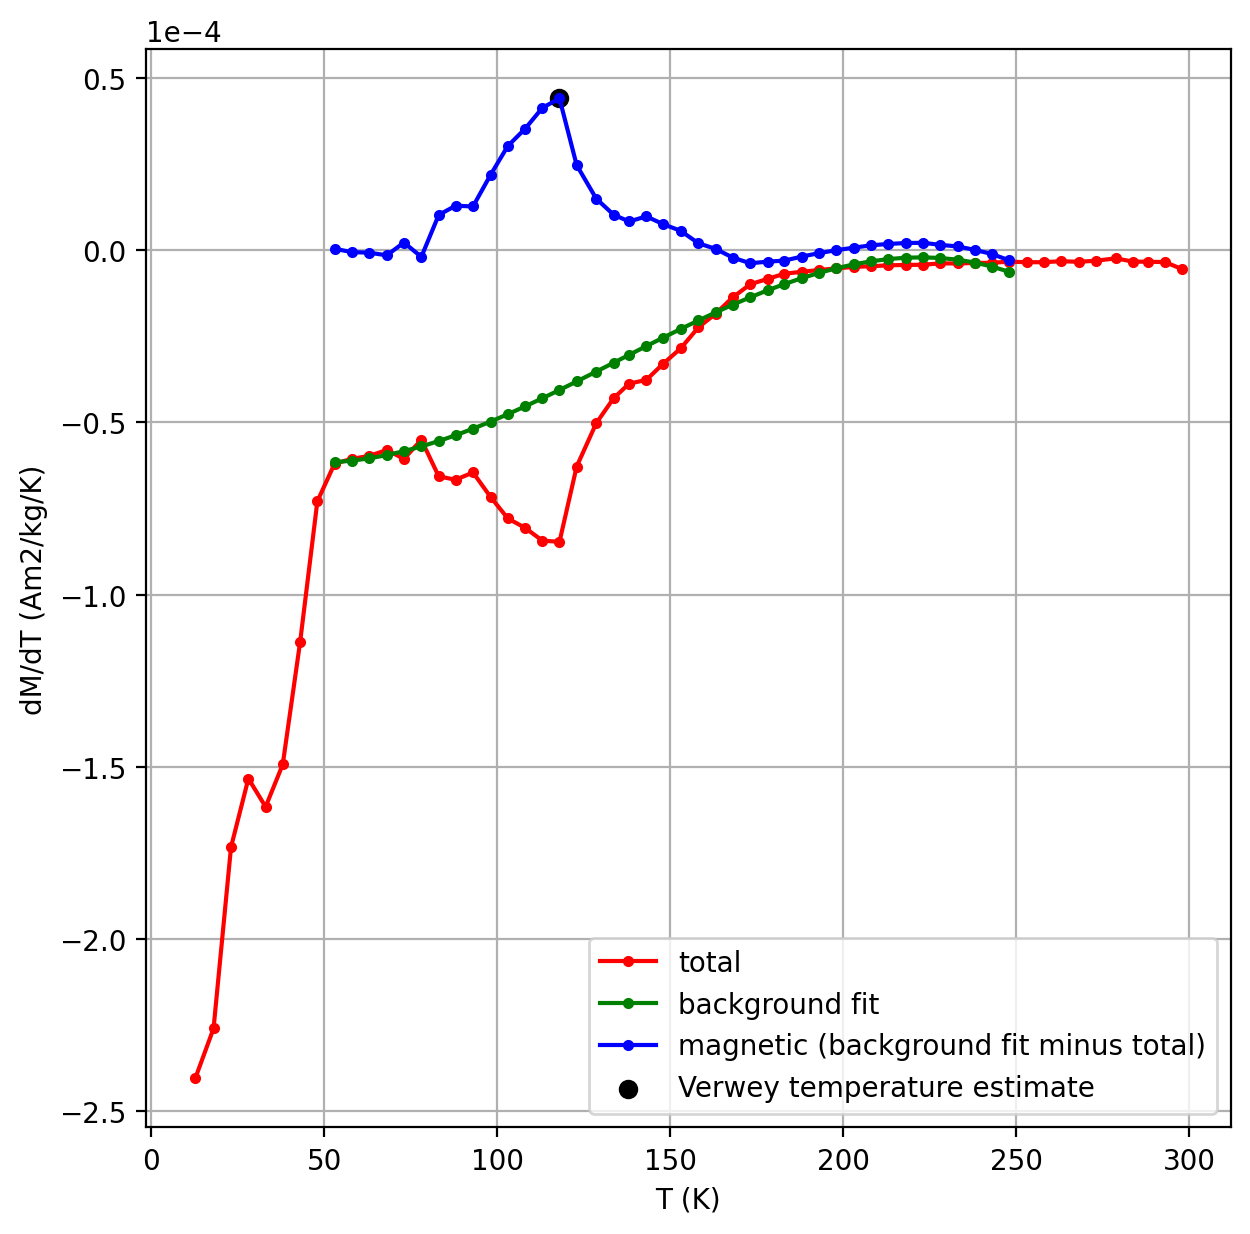

The T range for background fit is: 50 K to 250 K
The excluded T range is: 75 K to 150 K
The polynomial degree for background fit is: 3
The r-squared value for the background fit is: 0.99
The Verwey temperature estimate is: 118.0 K


In [40]:
temps = MPMS_FC['T [K]']
mags = MPMS_FC['M [Am2/kg]']

dM = mags.diff()
dT = temps.diff()
dM_dT = dM / dT
dM_dT_real = dM_dT[1:]
dM_dT_real.reset_index(drop=True, inplace=True)

temps_dM_dT = [(temps[n] + dT[n+1] / 2) for n in range(len(temps) - 1)]
temps_dM_dT = pd.Series(temps_dM_dT)

# Second Derivative
ddM_ddT = dM_dT.diff() / dT[1:].reset_index(drop=True)
ddM_ddT_real = ddM_ddT[1:]
ddM_ddT_real.reset_index(drop=True, inplace=True)

# Midpoints for second derivative
temps_ddM_ddT = [(temps_dM_dT[n] + (dT[n+1] / 2)) for n in range(len(temps_dM_dT) - 1)]
temps_ddM_ddT = pd.Series(temps_ddM_ddT)

# Final DataFrame
dM_dT_df = pd.DataFrame({'T': temps_dM_dT, 'dM_dT': dM_dT_real, 'T_2nd': temps_ddM_ddT, 'd2M_dT2': ddM_ddT_real})
    
fig = plt.figure(figsize=(7,7))
ax0 = fig.add_subplot(1,1,1)
ax0.plot(dM_dT_df['T'],dM_dT_df['dM_dT'],'.-',color='red',label='total')

t_range_background_min = 50
t_range_background_max = 250
excluded_t_min=75
excluded_t_max = 150
poly_deg = 3

temps_filtered_indices = [i for i in np.arange(len(temps_dM_dT)) if ((float(temps_dM_dT[i]) > float(t_range_background_min)) and (float(temps_dM_dT[i])  < float(excluded_t_min)) ) or ((float(temps_dM_dT[i]) > float(excluded_t_max)) and (float(temps_dM_dT[i])  < float(t_range_background_max)))]
temps_filtered = dM_dT_df['T'][temps_filtered_indices]
dM_dT_filtered = dM_dT_df['dM_dT'][temps_filtered_indices]

# ax0.plot(temps_filtered,dM_dT_filtered,'.-',color='grey',label='total (filtered)')

poly_background_fit = np.polyfit(temps_filtered, dM_dT_filtered, poly_deg)
dM_dT_filtered_polyfit = np.poly1d(poly_background_fit)(temps_filtered)

residuals = dM_dT_filtered - dM_dT_filtered_polyfit
ss_tot = np.sum((dM_dT_filtered - np.mean(dM_dT_filtered)) ** 2)
ss_res = np.sum(residuals ** 2)
r_squared = 1 - (ss_res / ss_tot)

temps_background_indices = [i for i in np.arange(len(temps_dM_dT)) if ((float(temps_dM_dT[i]) > float(t_range_background_min)) and (float(temps_dM_dT[i])  < float(t_range_background_max)))]
temps_background_indices = [i for i in np.arange(len(temps_dM_dT)) if ((float(temps_dM_dT[i]) > float(t_range_background_min)) and (float(temps_dM_dT[i])  < float(t_range_background_max)))]
temps_background = dM_dT_df['T'][temps_background_indices]
temps_background.reset_index(drop = True, inplace=True)
dM_dT_background = dM_dT_df['dM_dT'][temps_background_indices]

dM_dT_polyfit = np.poly1d(poly_background_fit)(temps_background)

mgt_dM_dT = dM_dT_polyfit - dM_dT_background 
mgt_dM_dT.reset_index(drop = True, inplace=True)

max_mgt_dM_dT = max(mgt_dM_dT)
max_mgt_dM_dT_index = mgt_dM_dT.argmax()
verwey_estimate = temps_background[max_mgt_dM_dT_index]

ax0.plot(temps_background,dM_dT_polyfit,'.-',color='green',label='background fit')
ax0.plot(temps_background,mgt_dM_dT,'.-',color='blue',label='magnetic (background fit minus total)')
ax0.scatter(verwey_estimate,max_mgt_dM_dT,color='black',label='Verwey temperature estimate')
ax0.set_ylabel('dM/dT (Am2/kg/K)')
ax0.set_xlabel('T (K)')
ax0.legend(loc='lower right')
ax0.grid(True)
ax0.ticklabel_format(axis='y', style='scientific', scilimits=(0,0))
plt.show()

print('The T range for background fit is: ' + str(t_range_background_min) + ' K to ' + str(t_range_background_max) + ' K')
print('The excluded T range is: ' + str(excluded_t_min) + ' K to ' + str(excluded_t_max) + ' K')
print('The polynomial degree for background fit is: ' + str(poly_deg))
print('The r-squared value for the background fit is: ' + str(round(r_squared,3)))
print('The Verwey temperature estimate is: ' + str(round(verwey_estimate,1)) + ' K')

In [41]:
dM_dT_df

,T,dM_dT,T_2nd,d2M_dT2
0,12.747282,-0.000240,15.50026,NaN
1,18.038580,-0.000226,20.57690,2.892276e-06
2,23.087200,-0.000173,25.59750,1.047932e-05
3,28.109225,-0.000153,30.62095,4.044838e-06
4,33.080585,-0.000162,35.54022,-1.644626e-06
5,38.035205,-0.000149,40.53019,2.454877e-06
6,43.039240,-0.000114,45.54829,7.102999e-06
7,48.041055,-0.000073,50.53382,8.251931e-06
8,53.017295,-0.000062,55.50077,2.198034e-06
9,57.983705,-0.000061,60.46664,2.732813e-07
